# Hands-on 2: kNN Notebook (Tutorial)

**Alumno:** _Herrera Covarrubias Kevin Shalom_  
**Curso / Profesor:** _Clasificacion Inteligente de Datos / Jose Antonio Aviña Mendez_



## Fundamentos de la técnica
El **kNN** clasifica por **vecindad**: busca los `k` puntos más cercanos y decide por **votación** (uniforme o ponderada por distancia). Es **no paramétrico** y **perezoso**.

## Modelo Matemático
Dado $\{(\mathbf{x}_i,y_i)\}$ y consulta $\mathbf{x}$: (1) calcular distancias; (2) tomar los `k` vecinos con menor distancia; (3) votar la clase, opcionalmente ponderando por $1/(d+\epsilon)$.

## Librerías / clases / funciones
- `sklearn.neighbors.KNeighborsClassifier` (`n_neighbors`, `weights`, `metric`).
- `sklearn.preprocessing.StandardScaler`.
- `sklearn.pipeline.Pipeline`.
- `sklearn.model_selection.train_test_split`.
- `sklearn.metrics`: `confusion_matrix`, `accuracy_score`.

## Pipeline
### a) Preprocesamiento (estadística básica + scatter)

Shape: (400, 5)
    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0

Estadística básica:
                       mean           std      min       max
Age                 37.655     10.482877     18.0      60.0
EstimatedSalary  69742.500  34096.960282  15000.0  150000.0


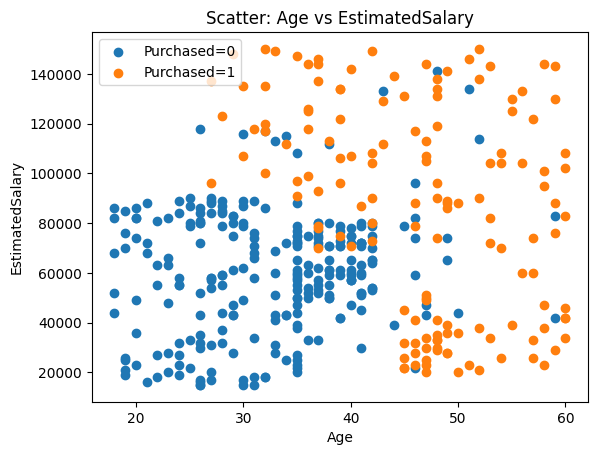

In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
DATA_PATH = Path('/content/Social_Network_Ads.csv')
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape); print(df.head())
stats = df[['Age','EstimatedSalary']].describe().T[['mean','std','min','max']]
print("\nEstadística básica:\n", stats)

plt.figure()
for cl, sub in df.groupby('Purchased'):
    plt.scatter(sub['Age'], sub['EstimatedSalary'], label=f'Purchased={cl}')
plt.xlabel('Age'); plt.ylabel('EstimatedSalary'); plt.title('Scatter: Age vs EstimatedSalary')
plt.legend(); plt.show()


### Explicación (Preprocesamiento)
Primero cargamos el dataset y revisamos estadísticas básicas (promedio, desviación, mínimo, máximo) de Age y EstimatedSalary.
Luego graficamos un scatter donde cada punto es una persona y el color indica si compró o no compró.
Este paso sirve para ver si hay patrones por vecindarios: grupos de puntos con comportamiento parecido.

### b) Feature Engineering
Elegimos Age y EstimatedSalary como variables porque son numéricas y fáciles de interpretar.
Como kNN usa distancias, más adelante escalamos estas variables para que ninguna domine por su magnitud.

### c) Model Training (fit)

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

X = df[['Age','EstimatedSalary']].values
y = df['Purchased'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

knn_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights='distance'))
])
knn_clf.fit(X_train, y_train)
print(knn_clf)


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(weights='distance'))])


### Explicación (Model Training — `fit`)
“Entrenamos un pipeline con StandardScaler y KNeighborsClassifier.
k=5 quiere decir que para un nuevo caso miramos los 5 vecinos más cercanos y decidimos por votación.
Con weights='distance', los vecinos más cercanos pesan más que los lejanos.”

### d) Prediction (función)

In [3]:

def predecir_patron(modelo, age, est_salary, nombres=('NoPurchase','Purchase')):
    import numpy as np
    v = np.array([[age, est_salary]])
    pred = int(modelo.predict(v)[0])
    print(f"Predicción: {pred} -> {nombres[pred]}")
    return pred

_ = predecir_patron(knn_clf, X_test[0,0], X_test[0,1])


Predicción: 0 -> NoPurchase


### Explicación (Prediction)
Creamos una función que recibe (Age, EstimatedSalary) y devuelve ‘Purchase’ o ‘NoPurchase’.
En palabras simples: el modelo mira a quiénes se parece ese punto y vota lo que hicieron esos vecinos.

### e) Model Evaluation

Accuracy: 0.91


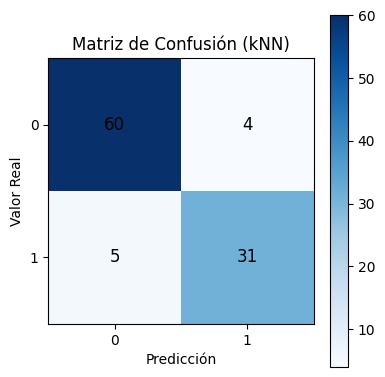

Diagonal = aciertos; fuera de diagonal = errores.


In [4]:
# --- Model Evaluation: Matriz de Confusión (gráfico simple con matplotlib) ---
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Predicciones y matriz
y_pred = knn_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.2f}")

# Gráfico simple de la matriz de confusión
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, cmap='Blues')
ax.set_title('Matriz de Confusión (kNN)')
ax.set_xlabel('Predicción')
ax.set_ylabel('Valor Real')

# Números dentro de cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

# Ticks si hay dos clases (0 y 1)
ax.set_xticks(range(cm.shape[1]))
ax.set_yticks(range(cm.shape[0]))
ax.set_xticklabels(['0','1'])
ax.set_yticklabels(['0','1'])

plt.colorbar(im)
plt.tight_layout()
plt.show()

# Nota explicativa mínima
print("Diagonal = aciertos; fuera de diagonal = errores.")

In [5]:

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = knn_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("Matriz de Confusión:\n", cm)
print(f"\nAccuracy: {acc:.4f}")
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, target_names=['NoPurchase','Purchase']))


Matriz de Confusión:
 [[60  4]
 [ 5 31]]

Accuracy: 0.9100

Reporte de clasificación:
               precision    recall  f1-score   support

  NoPurchase       0.92      0.94      0.93        64
    Purchase       0.89      0.86      0.87        36

    accuracy                           0.91       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.91      0.91      0.91       100



### Explicación (Model Evaluation)
La matriz de confusión muestra aciertos y errores por clase: la diagonal son aciertos.
El Accuracy es el porcentaje total de aciertos.
Con kNN suele ir mejor que con un modelo lineal (como el Perceptrón) porque kNN no necesita una línea recta: se adapta a la forma de los datos por vecindarios.

### Conclusión de los resultados
- kNN rinde bien cuando “**parecidos se comportan parecido**”.
- Si queremos más rendimiento: ajustar **k**, probar otros **pesos** y, si hay, añadir **más variables** informativas.

## Referencias bibliográficas
- Díaz, R. (2024, 6 julio). Algoritmo KNN – cómo funciona y ejemplos en Python. The Machine Learners. https://www.themachinelearners.com/algoritmo-knn
- DataCamp. (2024, 3 de mayo). K-Nearest Neighbors (KNN) clasificación con R: Tutorial. https://www.datacamp.com/es/tutorial/k-nearest-neighbors-knn-classification-with-r-tutorial
- Na, & Na. (2024b, octubre 30). Algoritmo K-Nearest Neighbor | Aprende Machine Learning. Aprende Machine Learning. https://www.aprendemachinelearning.com/clasificar-con-k-nearest-neighbor-ejemplo-en-python
